### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# visual_behavior_analysis package functions
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading

from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [5]:
# get useful information 
experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

In [6]:
# # visual_behavior_glm package functions
# import visual_behavior_glm.GLM_fit_dev as gfd
# import visual_behavior_glm.GLM_analysis_tools as gat
# import visual_behavior_glm.GLM_across_session as gas

## Load data

See the following notebooks to see how the files below were generated: 
* `save_filtered_metadata_tables.ipynb` 
* `figure_3_generate_analysis_files.ipynb` 
* `figure_4_generate_analysis_files.ipynb`

### Cache directory - where to save files

In [7]:
platform_cache_dir = loading.get_platform_analysis_cache_dir()
print(platform_cache_dir)

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new


In [8]:
clustering_results = os.path.join(platform_cache_dir, 'clustering')

If saved files already exist in the clustering_results directory, the files will be loaded below. 

To do a fresh run and generate new files, set clustering_results directory to an empty folder

### Load metadata tables

In [9]:
# metadata tables
experiments_table = pd.read_csv(os.path.join(platform_cache_dir, 'all_ophys_experiments_table.csv'), index_col=0)
platform_experiments = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_experiments_table.csv'), index_col=0)
platform_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_cells_table.csv'), index_col=0)
matched_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_matched_ophys_cells_table.csv'), index_col=0)

# get lists of matched cells and expts
matched_cells = matched_cells_table.cell_specimen_id.unique()
matched_experiments = matched_cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(platform_cells_table.cre_line.unique())
cell_types = utils.get_cell_types()


In [10]:
print(len(platform_experiments))

402


In [11]:
# we know that 5 experiments were dropped after filtering for cells matched in all 3 experience levels
# these experiments came from 2 fields of view, one in Sst and one in Vip, that only had a few cells in the imaging plane
print(len(matched_cells_table.ophys_experiment_id.unique()))
print(len(matched_cells_table.cell_specimen_id.unique()))

393
3921


#### Load GLM results

In [12]:
### GLM results ###

# define model version
glm_version = '24_events_all_L2_optimize_by_session'
 
# glm outputs
run_params = pd.read_pickle(os.path.join(platform_cache_dir, 'glm_results', glm_version+'_run_params.pkl'))

# for clustering analysis, we only want to use across session normalized coding scores
results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'across_session_normalized_platform_results_pivoted.h5'), key='df')


In [13]:
# the results pivoted table that we loaded above should only contain cells matched across sessions
# after across session normalization of dropout scores 
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))

393
3921


## Clustering methods

The goal of this clustering analysis is to evaluate patterns of changes in coding scores across sessions for individual neurons. Accordingly, the analysis is limited to cells that were matched across sessions with the three experience levels of interest (Familiar, Novel, Novel +). 

### Generate feature matrix of coding scores across experience levels

In [14]:
feature_matrix_path = os.path.join(platform_cache_dir, 'clustering', 'clustering_feature_matrix.h5')

if not os.path.exists(feature_matrix_path):
    print("Creating feature matrix...")
    # Make the feature matrix file
    feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=clustering_results)
    feature_matrix.to_hdf(feature_matrix_path, key='df')
    print("Feature matrix created and saved.")
else:
    print("Loading feature matrix...")
    # Load the feature matrix file
    feature_matrix = pd.read_hdf(feature_matrix_path, key='df')
    print("Feature matrix loaded.")


Loading feature matrix...
Feature matrix loaded.


In [15]:
# feature matrix should have same number of cells as matched cells table
print(len(matched_cells_table.cell_specimen_id.unique()))
print(len(feature_matrix))

3921
3921


### Selecting optimal number of clusters

In [21]:
# we are expecting 14 clusters based on previous emprical results, so we let's higlight k=14 on our plots below
expected_n_clusters = 14

#### Gap statistic method

In [22]:
metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors)
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(clustering_results, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
with open(gap_filename, 'rb') as f:
    gap_dict = pickle.load(f)

In [23]:
metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(clustering_results, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))

if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_dict = pickle.load(f)
        print('loaded file')
else:
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    gap_dict = processing.compute_gap(clustering=sc, data=feature_matrix, k_max=k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_dict, gap_filename)

loaded file


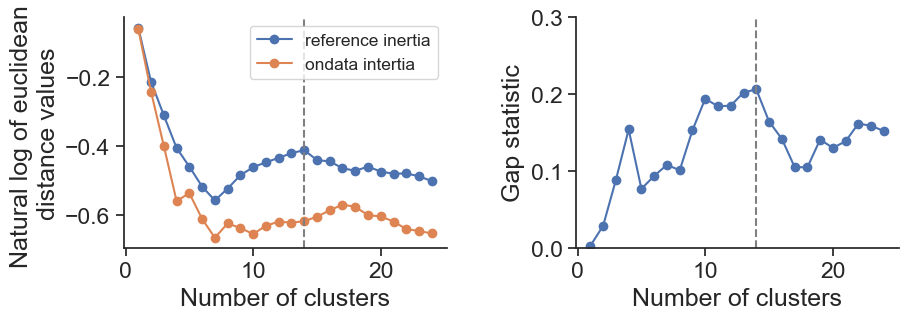

In [24]:
# plotting.plot_gap_statistic is not autoreloading
plotting.plot_gap_statistic(gap_dict, cre_lines=['all'], n_clusters_cre=expected_n_clusters, 
                            tag='with_cre_shuffle', save_dir=None, folder='selecting_k_clusters')

#### Eigen gap method

In [25]:
cre_line = 'all'
eigengap_filename = 'eigengap_' + glm_version + '_' + 'kmax' + str(k_max) + '_' + (cre_line) + '.pkl'
eigengap_path = os.path.join(clustering_results, eigengap_filename)
if os.path.exists(eigengap_path):
    print('loading eigengap values scores from', eigengap_path)
    with open(eigengap_path, 'rb') as f:
        eigengap = pickle.load(f)
        f.close()
else: 
    # this function will run eigengap if file does not exist
    eigengap = processing.load_eigengap(glm_version, feature_matrix, cre_line='all', save_dir=clustering_results, k_max=25)

loading eigengap values scores from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\clustering\eigengap_24_events_all_L2_optimize_by_session_kmax25_all.pkl


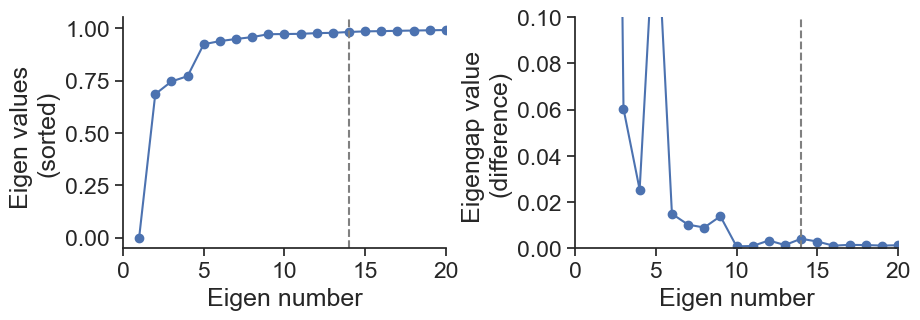

In [26]:
plotting.plot_eigengap_values(eigengap, cre_lines=['all'], n_clusters_cre={'all':expected_n_clusters}, save_dir=clustering_results, folder='selecting_k_clusters')

#### Silhouette Score method

In [27]:
n_clusters_range = np.arange(3, 25)
metric='euclidean'
n_boots=20

silhouette_filename= os.path.join(clustering_results, 'silhouette_score_{}_{}_clusters_metric_{}_nboots_{}.pkl'.format(n_clusters_range[0], n_clusters_range[-1], metric, n_boots))

if os.path.exists(silhouette_filename):
    with open(silhouette_filename, 'rb') as f:
        silhouette_scores, silhouette_std = pickle.load(f)
        print('loaded file')
else:
    from sklearn.cluster import SpectralClustering
    X=feature_matrix.values 
    silhouette_scores, silhouette_std = processing.get_silhouette_scores(X=X, model=SpectralClustering(), n_clusters=n_clusters_range, metric=metric, n_boots=n_boots)
    processing.save_clustering_results([silhouette_scores, silhouette_std], silhouette_filename)

loaded file


<Axes: xlabel='Number of clusters', ylabel='Silhouette score'>

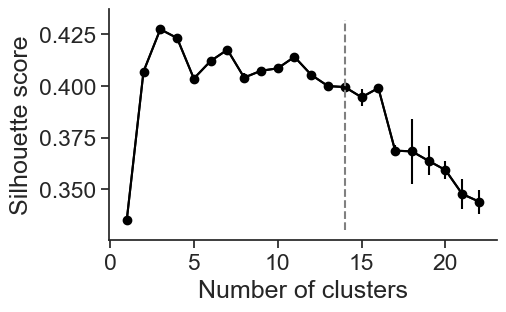

In [28]:
plotting.plot_silhouette_scores(silhouette_scores=silhouette_scores, silhouette_std=silhouette_std, metric=metric, 
                                n_clusters=expected_n_clusters, save_dir=clustering_results, folder='selecting_k_clusters')

### Run clustering

Procedure: 
* Run co-clustering using spectral clustering to identify pairs of cells that reliably co-cluster over many iterations
* Run agglomerative hierarchical clustering on co-clustering matrix to identify grouops of cells that reliably co-cluster
* Create dataframe containing all matched cells and their assigned cluster ID labels for use in subsequent analysis

#### Select number of clusters based on methods above


In [29]:
n_clusters = 14

#### Get co-clustering matrix

In [30]:
coclust_filename = os.path.join(clustering_results, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
if os.path.exists(coclust_filename):    
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
else:    
    from sklearn.cluster import SpectralClustering
    X=feature_matrix.values 
    coclustering_matrix = processing.get_coClust_matrix(X, model=SpectralClustering, nboot=np.arange(150), n_clusters=n_clusters)
    coclustering_df = pd.DataFrame(coclustering_matrix)
    coclustering_df.to_hdf(coclust_filename, key='df')

#### Hierarchical cluster id assignment

Create cluster_metadata table which includes the cluster ID assignment for each cell specimen ID

In [31]:
##### ADD TO GENERATE ANALYSIS FILES notebook 
cluster_meta_filename = os.path.join(clustering_results, f'cluster_meta_{n_clusters}_clusters.h5')
if os.path.exists(cluster_meta_filename):
    cluster_meta = pd.read_hdf(cluster_meta_filename, key='df')
    print('found and loaded cached cluster_meta file...')
else:
    print('did not find cached cluster_meta file, will make one...')
    cluster_meta = processing.run_hierarchical_clustering_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, 
                                                            matched_cells_table, cluster_meta_filename)
    # function uses this to cluster then creates metadata table with labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
    labels = cluster.fit_predict(X)

did not find cached cluster_meta file, will make one...


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


3921 cells in cell_metadata for feature_matrix
dropping 5 cells for ('Slc17a7-IRES2-Cre', 13)
dropping 3 cells for ('Slc17a7-IRES2-Cre', 14)
dropping 2 cells for ('Sst-IRES-Cre', 10)
dropping 3 cells for ('Sst-IRES-Cre', 11)
dropping 1 cells for ('Sst-IRES-Cre', 12)
dropping 5 cells for ('Vip-IRES-Cre', 4)
dropping 1 cells for ('Vip-IRES-Cre', 14)
20 cells dropped total
Created and saved cluster_meta file.


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [32]:
# cluster metadata table will have 20 fewer cells than the input feature matrix because
# we remove cells for a given cre line if there are only 5 or less in a given cluster
print(len(feature_matrix))
print(len(cluster_meta))

3921
3901


In [33]:
# this also results in dropping two clusters because they last two clusters both had fewer than 5 cells of each cre line
print(n_clusters)
print(len(cluster_meta.cluster_id.unique()))

14
12


<Axes: ylabel='cells'>

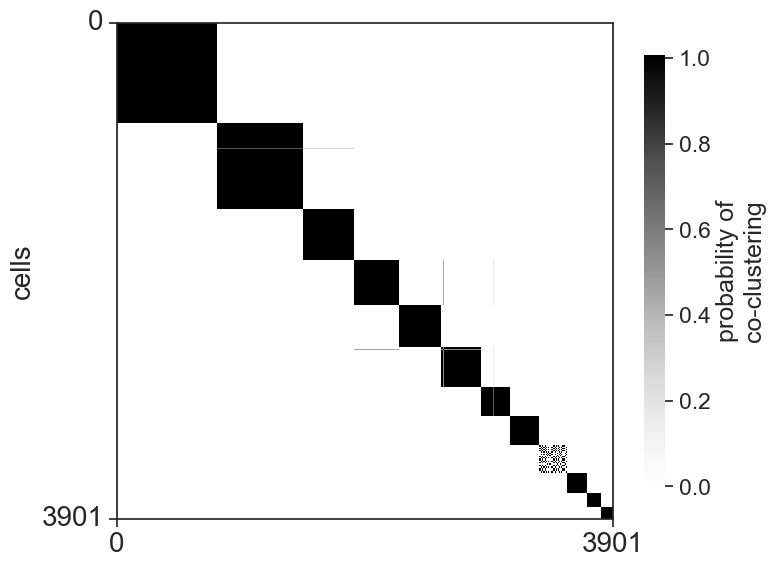

In [34]:
# plot co-clustering matrix 
coclustering_dict = {}
coclustering_dict['all'] = coclustering_df
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cre_line'] = 'all'

plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
                                                                 suffix='_' + str(n_clusters) + '_clusters', 
                                                                 save_dir=None, folder='clustering_results')

### Cluster validation

#### Within cluster correlation

adding within cluster correlation to cluster_meta


c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\marinag\Anaconda3\envs\visual_behavior_sdk_new\lib\site-packages\numpy\lib\functi

<Axes: title={'center': 'Within cluster correlation'}, xlabel='Cluster ID', ylabel='Spearman\ncorrelation'>

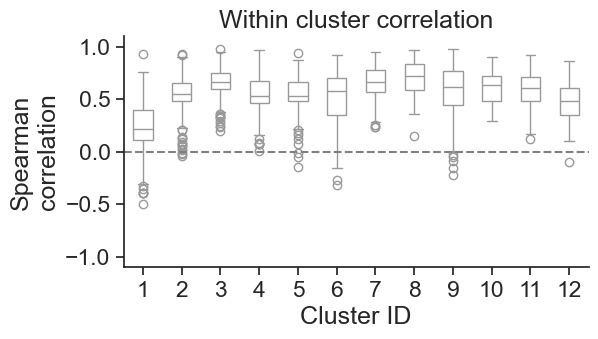

In [35]:
# plot within cluster correlations distribution
spearman = True
cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=spearman)
plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=spearman, suffix='_'+str(n_clusters)+'_clusters',
                                                save_dir=None, folder='clustering_results', ax=None)

In [36]:
# # plot within cluster correlations distribution
# spearman = False
# cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=spearman)
# plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=spearman, suffix='_'+str(n_clusters)+'_clusters',
#                                                 save_dir=save_dir, folder='clustering_results', ax=None)

#### UMAP

In [37]:
# Run umap or get saved results
umap_df = processing.get_umap_results(feature_matrix, cluster_meta, save_dir=clustering_results, suffix='')

loading umap results from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\clustering\umap_results_df.h5


using provided umap_df


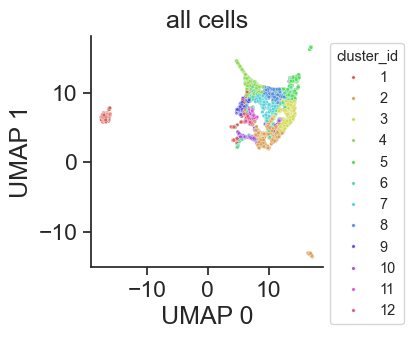

In [38]:
# show all clusters in same plot
plotting.plot_umap_for_clusters(cluster_meta, feature_matrix, umap_df, label_col='cluster_id', cre_lines = ['all'],
                                save_dir=None, folder='cluster_results')

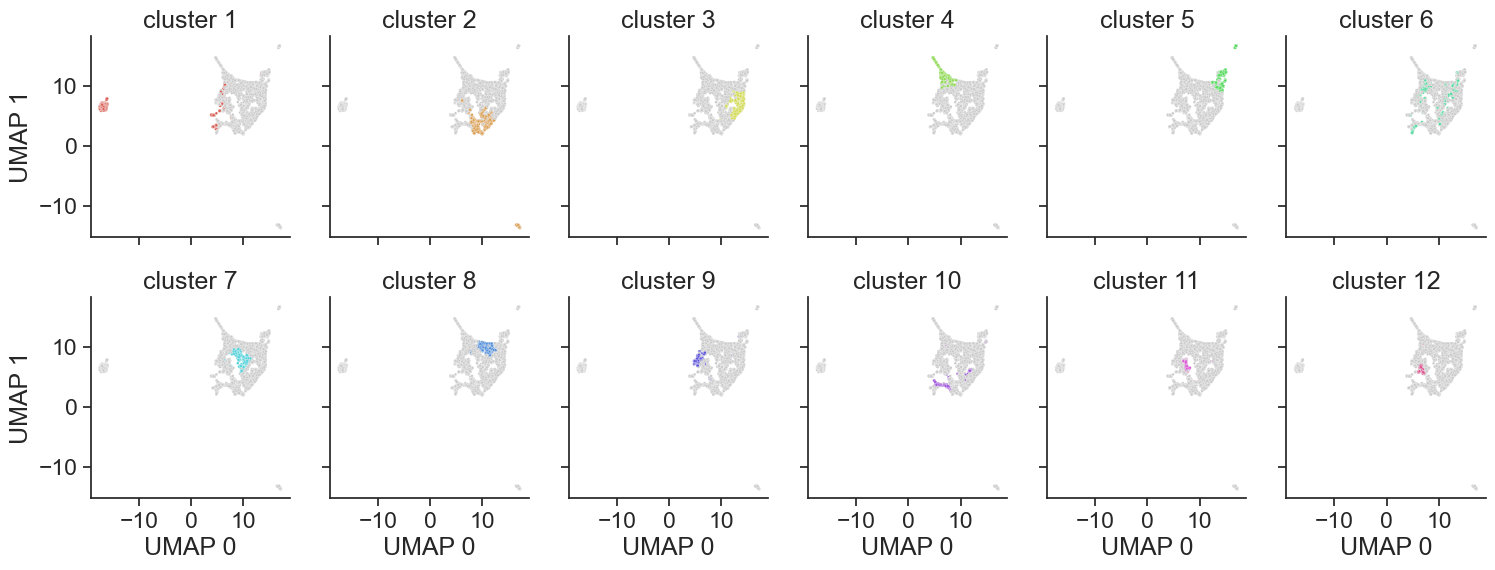

In [39]:
# plot clusters in separate axes
plotting.plot_umap_for_clusters_separately(cluster_meta, feature_matrix, umap_df, label_col='cluster_id', save_dir=None, folder='clustering_results')

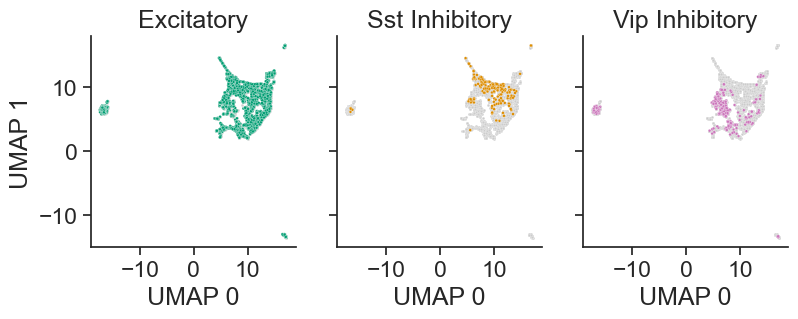

In [40]:
# plot cell type distribution 
cmap = utils.get_cell_type_colors()
plotting.plot_umap_for_features_separately(cluster_meta, feature_matrix, umap_df, label_col='cell_type', cmap=cmap, save_dir=None, folder='clustering_results')

## Metrics

### Generate table of coding score metrics

In [41]:
# this function computes metrics on coding scores for cells matched across sessions (in results_pivoted)
coding_score_metrics = processing.generate_coding_score_metrics_table(cluster_meta, results_pivoted, 
                                                                      save_dir=clustering_results)

loading coding score metrics table


### Generate merged table of coding scores and model free metrics

The function below computes (or loads) a table of metrics computed for cell responses (model free metrics) and merges it with a table of coding score values for matched cells

In [42]:
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=clustering_results)

loading coding score and model free metrics table


In [43]:
print(len(metrics.ophys_experiment_id.unique()))
print(len(metrics.cell_specimen_id.unique()))

393
3901
